In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn. metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#         LOAD & PREPARE DATA

In [48]:
unlabelled_df = pd.read_csv("../data/all_data.csv")
unlabelled_df.head()


unlabelled_df["Timestamp"] = pd. to_datetime(unlabelled_df["Timestamp"])
unlabelled_df["Timestamp"] = unlabelled_df["Timestamp"].astype("int64") // 10**9

In [49]:
unlabelled_df.head()

,Timestamp,PID,Process_Name,Power_W,CPU_Usage_%,Mem_Usage_MB
0,1765025201,226,loginwindow,0.0645,4.3,32.679688
1,1765025201,270,PlugInLibraryService,0.0000,0.0,1.574219
2,1765025201,454,distnoted,0.0000,0.0,3.117188
3,1765025201,455,cfprefsd,0.0000,0.0,4.304688
4,1765025201,456,UserEventAgent,0.0000,0.0,5.968750


#        SEPARATE FEATURES & TARGET

In [50]:
X = unlabelled_df.drop(["PID", "Process_Name"], axis=1, errors='ignore')

print("\nFeatures:")
print(X.head())
print(f"\nShape: {X.shape}")

num_cols = ["Power_W", "CPU_Usage_%", "Mem_Usage_MB", "Timestamp"]


Features:
    Timestamp  Power_W  CPU_Usage_%  Mem_Usage_MB
0  1765025201   0.0645          4.3     32.679688
1  1765025201   0.0000          0.0      1.574219
2  1765025201   0.0000          0.0      3.117188
3  1765025201   0.0000          0.0      4.304688
4  1765025201   0.0000          0.0      5.968750

Shape: (2263, 4)


# Preprocessing

In [51]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
    ],
    remainder="drop"
)

X_scaled = preprocess.fit_transform(X)
print(f"\nScaled data shape: {X_scaled.shape}")


Scaled data shape: (2263, 4)


# ===========================================
#         ONLINE ISOLATION FOREST
# ===========================================

Processing 2263 samples in batches of 100...
  Processed batch 10
  Processed batch 20

Isolation Forest Results:
  Total samples: 2263
  Normal: 2149
  Anomalies detected: 114
  Anomaly rate: 5.04%


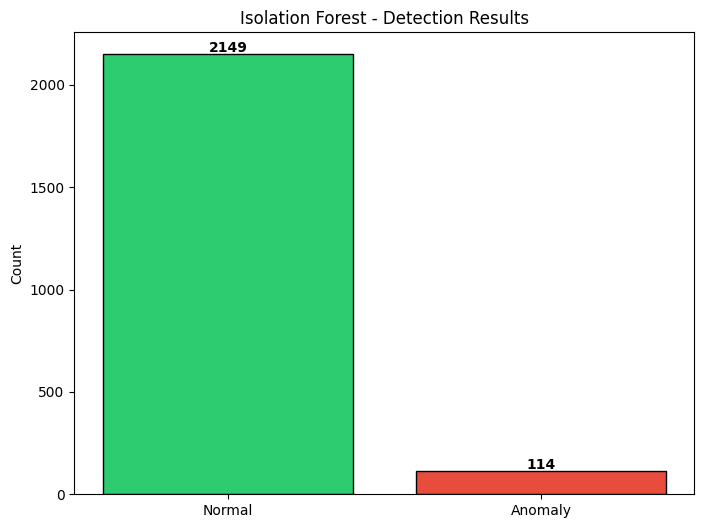

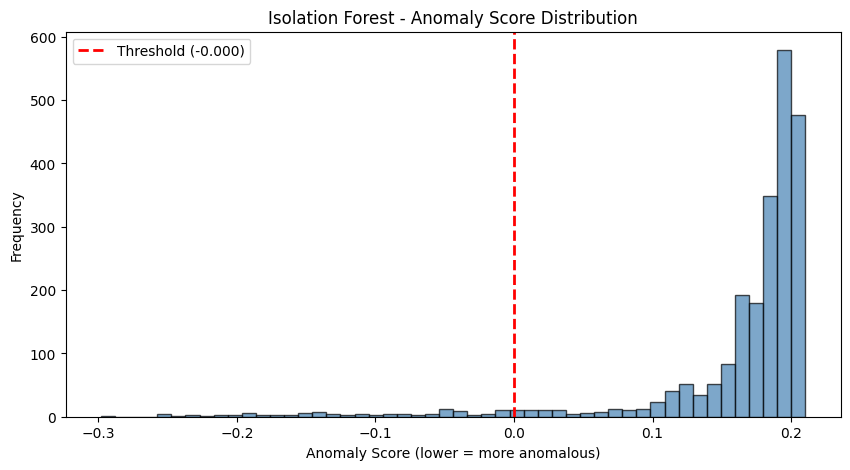

In [52]:
class OnlineIsolationForest:
    """
    Online/Incremental Isolation Forest implementation. 
    Processes data in batches and can update with new data.
    """
    def __init__(self, n_estimators=100, contamination=0.05, batch_size=100):
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.batch_size = batch_size
        self.model = None
        self.data_buffer = []
        
    def partial_fit(self, X_batch):
        """Incrementally fit the model with new data batch."""
        self.data_buffer. extend(X_batch. tolist())
        
        if len(self.data_buffer) >= self.batch_size:
            self.model = IsolationForest(
                n_estimators=self.n_estimators,
                contamination=self.contamination,
                random_state=42,
                warm_start=True,
                n_jobs=-1
            )
            self.model.fit(np.array(self. data_buffer))
            
    def fit(self, X):
        """Fit the model with all data."""
        self.model = IsolationForest(
            n_estimators=self.n_estimators,
            contamination=self.contamination,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(X)
        return self
            
    def predict(self, X):
        """Predict anomalies: -1 for anomaly, 1 for normal."""
        return self.model.predict(X)
    
    def decision_function(self, X):
        """Return anomaly scores (lower = more anomalous)."""
        return self.model.decision_function(X)

# Initialize Online Isolation Forest
online_iforest = OnlineIsolationForest(
    n_estimators=200,
    contamination=0.05,
    batch_size=100
)

# Simulate online processing (batch by batch)
batch_size = 100
print(f"Processing {len(X_scaled)} samples in batches of {batch_size}...")

for i in range(0, len(X_scaled), batch_size):
    batch = X_scaled[i:i+batch_size]
    online_iforest. partial_fit(batch)
    if (i // batch_size + 1) % 10 == 0:
        print(f"  Processed batch {i // batch_size + 1}")

# Final fit if model not created (small dataset)
if online_iforest. model is None:
    online_iforest.fit(X_scaled)

# PREDICTION
y_pred_iforest = online_iforest.predict(X_scaled)
iforest_scores = online_iforest. decision_function(X_scaled)

# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
y_pred_iforest_binary = np.where(y_pred_iforest == -1, 1, 0)

print(f"\nIsolation Forest Results:")
print(f"  Total samples: {len(X_scaled)}")
print(f"  Normal: {(y_pred_iforest == 1).sum()}")
print(f"  Anomalies detected: {(y_pred_iforest == -1).sum()}")
print(f"  Anomaly rate: {(y_pred_iforest == -1).sum() / len(X_scaled) * 100:.2f}%")

# Visualization: Detection Results
plt.figure(figsize=(8, 6))
labels = ['Normal', 'Anomaly']
counts = [(y_pred_iforest == 1).sum(), (y_pred_iforest == -1). sum()]
colors = ['#2ecc71', '#e74c3c']
plt.bar(labels, counts, color=colors, edgecolor='black')
plt.ylabel('Count')
plt.title('Isolation Forest - Detection Results')
for i, v in enumerate(counts):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.show()

# Anomaly Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(iforest_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
threshold = np.percentile(iforest_scores, 5)
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
plt.xlabel('Anomaly Score (lower = more anomalous)')
plt.ylabel('Frequency')
plt.title('Isolation Forest - Anomaly Score Distribution')
plt.legend()
plt.show()

# ===========================================
#         ONLINE LOCAL OUTLIER FACTOR (LOF)
# ===========================================

Initial fit with 200 samples...
Updating with batches of 100...
  Updated batch 10
  Updated batch 20

LOF Results:
  Total samples: 2263
  Normal: 2154
  Anomalies detected: 109
  Anomaly rate: 4.82%


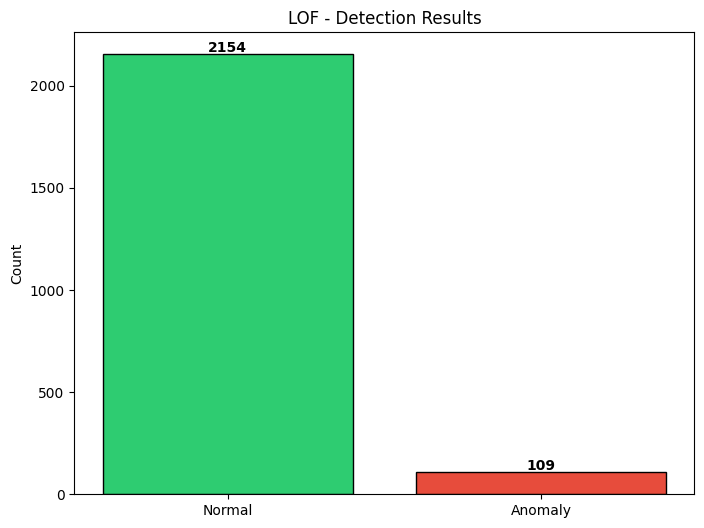

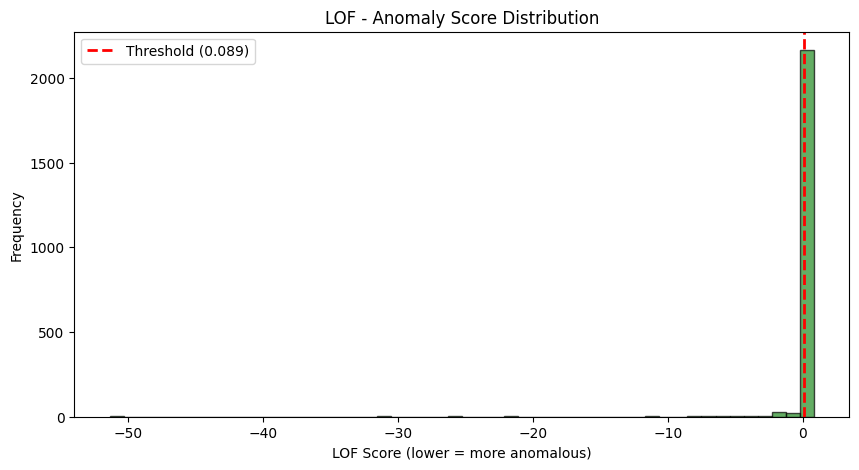

In [53]:
class OnlineLOF:
    """
    Online/Incremental LOF implementation.
    Uses novelty detection mode for online prediction.
    """
    def __init__(self, n_neighbors=20, contamination=0.05):
        self. n_neighbors = n_neighbors
        self.contamination = contamination
        self. model = None
        self.training_data = None
        
    def fit(self, X):
        """Fit the model with initial training data."""
        self.training_data = X. copy()
        self.model = LocalOutlierFactor(
            n_neighbors=min(self.n_neighbors, len(X) - 1),
            contamination=self. contamination,
            novelty=True,
            n_jobs=-1
        )
        self.model.fit(X)
        return self
        
    def partial_fit(self, X_new):
        """Update model with new data points."""
        if self.training_data is None:
            self.training_data = X_new.copy()
        else:
            self.training_data = np. vstack([self. training_data, X_new])
        
        self.model = LocalOutlierFactor(
            n_neighbors=min(self. n_neighbors, len(self.training_data) - 1),
            contamination=self.contamination,
            novelty=True,
            n_jobs=-1
        )
        self.model.fit(self.training_data)
        
    def predict(self, X):
        """Predict anomalies: -1 for anomaly, 1 for normal."""
        return self.model.predict(X)
    
    def decision_function(self, X):
        """Return LOF scores (lower = more anomalous)."""
        return self.model.decision_function(X)

# Initialize Online LOF
online_lof = OnlineLOF(
    n_neighbors=20,
    contamination=0.05
)

# Initial fit with first batch
initial_batch_size = min(200, len(X_scaled))
print(f"Initial fit with {initial_batch_size} samples...")
online_lof.fit(X_scaled[:initial_batch_size])

# Simulate online updates with remaining data
update_batch_size = 100
print(f"Updating with batches of {update_batch_size}...")

for i in range(initial_batch_size, len(X_scaled), update_batch_size):
    batch = X_scaled[i:i+update_batch_size]
    online_lof.partial_fit(batch)
    if ((i - initial_batch_size) // update_batch_size + 1) % 10 == 0:
        print(f"  Updated batch {(i - initial_batch_size) // update_batch_size + 1}")

# PREDICTION
y_pred_lof = online_lof.predict(X_scaled)
lof_scores = online_lof.decision_function(X_scaled)

# Convert predictions
y_pred_lof_binary = np.where(y_pred_lof == -1, 1, 0)

print(f"\nLOF Results:")
print(f"  Total samples: {len(X_scaled)}")
print(f"  Normal: {(y_pred_lof == 1).sum()}")
print(f"  Anomalies detected: {(y_pred_lof == -1).sum()}")
print(f"  Anomaly rate: {(y_pred_lof == -1). sum() / len(X_scaled) * 100:.2f}%")

# Detection Results Bar Chart
plt.figure(figsize=(8, 6))
labels = ['Normal', 'Anomaly']
counts = [(y_pred_lof == 1). sum(), (y_pred_lof == -1).sum()]
colors = ['#2ecc71', '#e74c3c']
plt. bar(labels, counts, color=colors, edgecolor='black')
plt.ylabel('Count')
plt.title('LOF - Detection Results')
for i, v in enumerate(counts):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.show()

# LOF Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(lof_scores, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
threshold_lof = np. percentile(lof_scores, 5)
plt.axvline(x=threshold_lof, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_lof:.3f})')
plt.xlabel('LOF Score (lower = more anomalous)')
plt.ylabel('Frequency')
plt.title('LOF - Anomaly Score Distribution')
plt.legend()
plt.show()



PROBABILITY-BASED ENSEMBLE FUSION
Isolation Forest Probability Range: [0.0000, 1.0000]
LOF Probability Range: [0.0000, 1.0000]

[Strategy 1] Simple Averaging:
  Threshold: 0.5
  Anomalies detected: 18
  Anomaly rate: 0.80%

[Strategy 2] Weighted Averaging (IF: 0.6, LOF: 0.4):
  Threshold: 0.5
  Anomalies detected: 32
  Anomaly rate: 1.41%

[Strategy 3] Maximum Probability:
  Threshold: 0.5
  Anomalies detected: 88
  Anomaly rate: 3.89%

[Strategy 4a] Voting (Union - Either method):
  Anomalies detected: 147
  Anomaly rate: 6.50%

[Strategy 4b] Voting (Intersection - Both methods):
  Anomalies detected: 76
  Anomaly rate: 3.36%


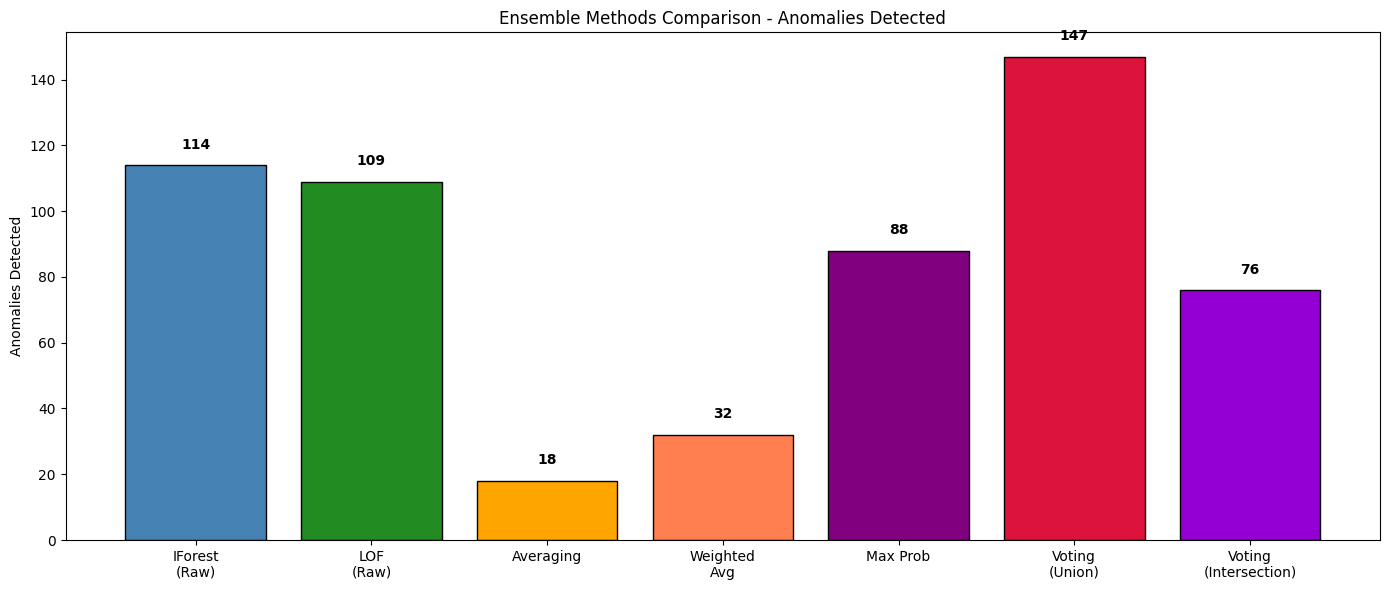

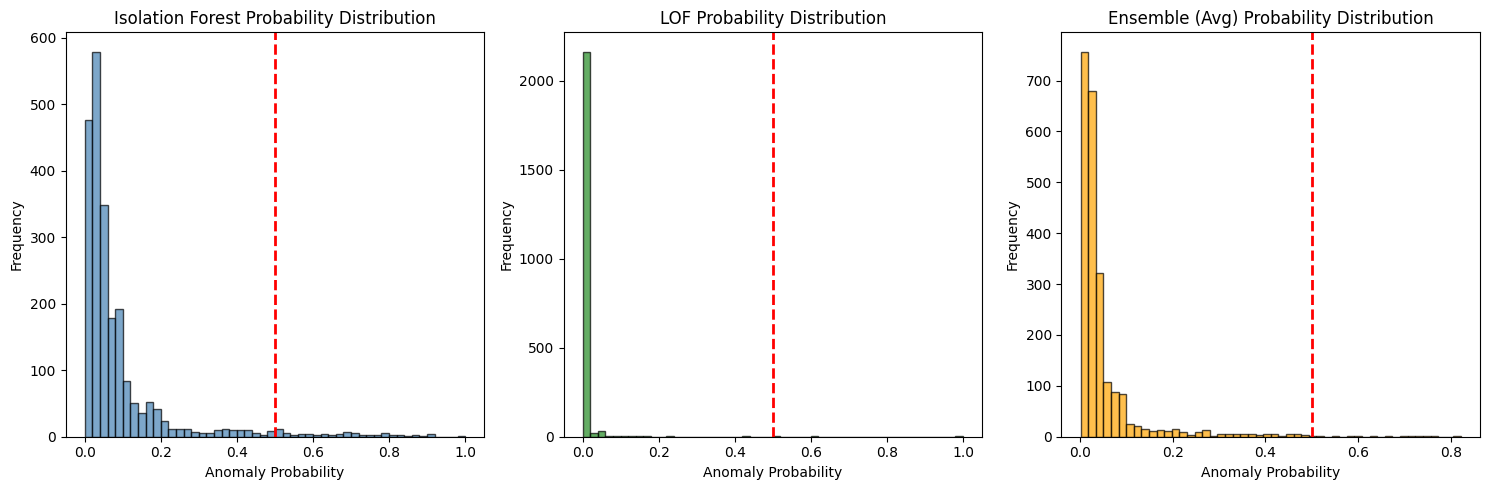

In [56]:
# ╔═════════════════════════════════════════════════════════════════════════════╗
# ║                    PROBABILITY-BASED ENSEMBLE FUSION                         ║
# ╚═════════════════════════════════════════════════════════════════════════════╝
print("\n" + "=" * 60)
print("PROBABILITY-BASED ENSEMBLE FUSION")
print("=" * 60)

# ===========================================
# Convert scores to probabilities [0, 1]
# Higher probability = more likely anomaly
# ===========================================

# Isolation Forest: scores are typically in range [-0.5, 0.5]
# Lower score = more anomalous, so we invert
scaler_iforest = MinMaxScaler()
iforest_prob = 1 - scaler_iforest.fit_transform(iforest_scores.reshape(-1, 1)). flatten()

# LOF: scores are typically negative for anomalies
# Lower score = more anomalous, so we invert
scaler_lof = MinMaxScaler()
lof_prob = 1 - scaler_lof.fit_transform(lof_scores.reshape(-1, 1)).flatten()

print(f"Isolation Forest Probability Range: [{iforest_prob. min():.4f}, {iforest_prob.max():.4f}]")
print(f"LOF Probability Range: [{lof_prob.min():.4f}, {lof_prob.max():.4f}]")

# ===========================================
# Ensemble Strategy 1: Simple Averaging
# ===========================================
ensemble_prob_avg = (iforest_prob + lof_prob) / 2
ensemble_pred_avg = (ensemble_prob_avg >= 0.5). astype(int)

print(f"\n[Strategy 1] Simple Averaging:")
print(f"  Threshold: 0.5")
print(f"  Anomalies detected: {ensemble_pred_avg. sum()}")
print(f"  Anomaly rate: {ensemble_pred_avg. sum() / len(X_scaled) * 100:.2f}%")

# ===========================================
# Ensemble Strategy 2: Weighted Averaging
# ===========================================
weight_iforest = 0.6  # Give more weight to Isolation Forest
weight_lof = 0.4

ensemble_prob_weighted = (weight_iforest * iforest_prob + weight_lof * lof_prob)
ensemble_pred_weighted = (ensemble_prob_weighted >= 0.5).astype(int)

print(f"\n[Strategy 2] Weighted Averaging (IF: {weight_iforest}, LOF: {weight_lof}):")
print(f"  Threshold: 0.5")
print(f"  Anomalies detected: {ensemble_pred_weighted.sum()}")
print(f"  Anomaly rate: {ensemble_pred_weighted.sum() / len(X_scaled) * 100:.2f}%")

# ===========================================
# Ensemble Strategy 3: Maximum Probability
# ===========================================
ensemble_prob_max = np.maximum(iforest_prob, lof_prob)
ensemble_pred_max = (ensemble_prob_max >= 0.5).astype(int)

print(f"\n[Strategy 3] Maximum Probability:")
print(f"  Threshold: 0.5")
print(f"  Anomalies detected: {ensemble_pred_max.sum()}")
print(f"  Anomaly rate: {ensemble_pred_max. sum() / len(X_scaled) * 100:.2f}%")

# ===========================================
# Ensemble Strategy 4: Voting (Union/Intersection)
# ===========================================
y_pred_ensemble_union = np.where(
    (y_pred_iforest == -1) | (y_pred_lof == -1), 1, 0
)
y_pred_ensemble_intersection = np.where(
    (y_pred_iforest == -1) & (y_pred_lof == -1), 1, 0
)

print(f"\n[Strategy 4a] Voting (Union - Either method):")
print(f"  Anomalies detected: {y_pred_ensemble_union.sum()}")
print(f"  Anomaly rate: {y_pred_ensemble_union.sum() / len(X_scaled) * 100:.2f}%")

print(f"\n[Strategy 4b] Voting (Intersection - Both methods):")
print(f"  Anomalies detected: {y_pred_ensemble_intersection.sum()}")
print(f"  Anomaly rate: {y_pred_ensemble_intersection. sum() / len(X_scaled) * 100:.2f}%")

# ===========================================
# Visualization: Ensemble Comparison
# ===========================================
plt.figure(figsize=(14, 6))

methods = [
    'IForest\n(Raw)', 
    'LOF\n(Raw)', 
    'Averaging', 
    'Weighted\nAvg', 
    'Max Prob', 
    'Voting\n(Union)', 
    'Voting\n(Intersection)'
]
anomaly_counts = [
    (y_pred_iforest == -1).sum(),
    (y_pred_lof == -1).sum(),
    ensemble_pred_avg. sum(),
    ensemble_pred_weighted. sum(),
    ensemble_pred_max. sum(),
    y_pred_ensemble_union.sum(),
    y_pred_ensemble_intersection.sum()
]
colors = ['steelblue', 'forestgreen', 'orange', 'coral', 'purple', 'crimson', 'darkviolet']

bars = plt.bar(methods, anomaly_counts, color=colors, edgecolor='black')
plt.ylabel('Anomalies Detected')
plt.title('Ensemble Methods Comparison - Anomalies Detected')
for bar, count in zip(bars, anomaly_counts):
    plt.text(bar. get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# ===========================================
# Probability Distribution Comparison
# ===========================================
fig, axes = plt. subplots(1, 3, figsize=(15, 5))

axes[0].hist(iforest_prob, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0]. set_xlabel('Anomaly Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Isolation Forest Probability Distribution')

axes[1].hist(lof_prob, bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Anomaly Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('LOF Probability Distribution')

axes[2].hist(ensemble_prob_avg, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[2].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[2]. set_xlabel('Anomaly Probability')
axes[2]. set_ylabel('Frequency')
axes[2].set_title('Ensemble (Avg) Probability Distribution')

plt.tight_layout()
plt.show()


RISK SCORE & ALERT GENERATION

Alert Level Distribution:
Alert_Level
🟢 MINIMAL     2108
🔵 LOW           97
🟡 MEDIUM        43
🟠 HIGH          14
🔴 CRITICAL       1
Name: count, dtype: int64


/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/2850737106.py:65: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/2850737106.py:65: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/2850737106.py:65: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/2850737106.py:65: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/2850737106.py:65: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/apple/Desktop/J.E.R.O.T.I..O/JEROTI/.venv/lib/pyt

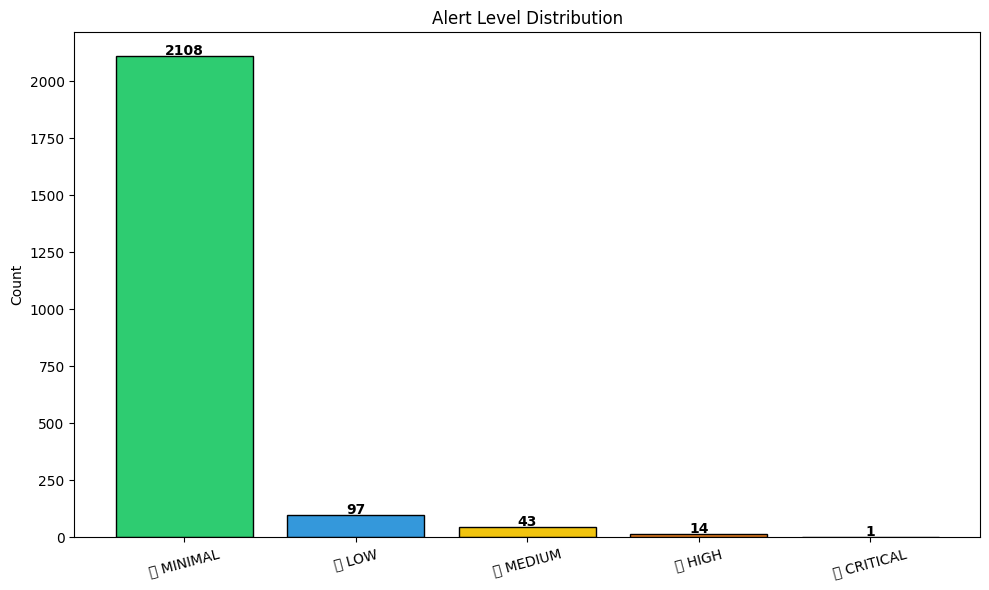

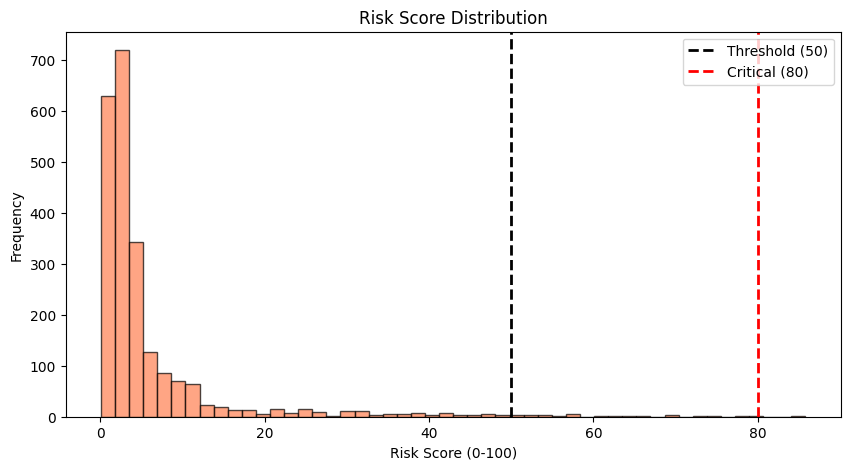

In [57]:
# ╔═════════════════════════════════════════════════════════════════════════════╗
# ║                         RISK SCORE & ALERTS                                  ║
# ╚═════════════════════════════════════════════════════════════════════════════╝
print("\n" + "=" * 60)
print("RISK SCORE & ALERT GENERATION")
print("=" * 60)

def get_alert_level(risk_score):
    """Determine alert level based on risk score (0-100)."""
    if risk_score >= 80:
        return "🔴 CRITICAL", "Immediate action required"
    elif risk_score >= 60:
        return "🟠 HIGH", "Investigation recommended"
    elif risk_score >= 40:
        return "🟡 MEDIUM", "Monitor closely"
    elif risk_score >= 20:
        return "🔵 LOW", "Normal monitoring"
    else:
        return "🟢 MINIMAL", "No action needed"

# Calculate risk scores (0-100)
risk_scores = ensemble_prob_weighted * 100

# Add to dataframe
unlabelled_df['IForest_Prediction'] = y_pred_iforest
unlabelled_df['IForest_Score'] = iforest_scores
unlabelled_df['IForest_Prob'] = iforest_prob
unlabelled_df['LOF_Prediction'] = y_pred_lof
unlabelled_df['LOF_Score'] = lof_scores
unlabelled_df['LOF_Prob'] = lof_prob
unlabelled_df['Ensemble_Prob'] = ensemble_prob_weighted
unlabelled_df['Risk_Score'] = risk_scores
unlabelled_df['Ensemble_Prediction'] = ensemble_pred_weighted
unlabelled_df['Is_Anomaly'] = unlabelled_df['Ensemble_Prediction']. apply(
    lambda x: 'Anomaly' if x == 1 else 'Normal'
)
unlabelled_df['Alert_Level'] = unlabelled_df['Risk_Score'].apply(
    lambda x: get_alert_level(x)[0]
)
unlabelled_df['Alert_Action'] = unlabelled_df['Risk_Score'].apply(
    lambda x: get_alert_level(x)[1]
)

# Alert Level Distribution
print("\nAlert Level Distribution:")
print(unlabelled_df['Alert_Level'].value_counts())

# Visualization: Alert Level Distribution
plt.figure(figsize=(10, 6))
alert_counts = unlabelled_df['Alert_Level'].value_counts()
colors_alert = {
    '🔴 CRITICAL': '#e74c3c',
    '🟠 HIGH': '#e67e22',
    '🟡 MEDIUM': '#f1c40f',
    '🔵 LOW': '#3498db',
    '🟢 MINIMAL': '#2ecc71'
}
bar_colors = [colors_alert. get(level, 'gray') for level in alert_counts. index]
plt.bar(alert_counts.index, alert_counts.values, color=bar_colors, edgecolor='black')
plt.ylabel('Count')
plt.title('Alert Level Distribution')
plt.xticks(rotation=15)
for i, v in enumerate(alert_counts. values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Risk Score Distribution
plt. figure(figsize=(10, 5))
plt.hist(risk_scores, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.axvline(x=50, color='black', linestyle='--', linewidth=2, label='Threshold (50)')
plt. axvline(x=80, color='red', linestyle='--', linewidth=2, label='Critical (80)')
plt. xlabel('Risk Score (0-100)')
plt.ylabel('Frequency')
plt. title('Risk Score Distribution')
plt.legend()
plt.show()


FEATURE IMPORTANCE


/var/folders/fb/c7ny9c1x1cz9sf687_4xwrrm0000gn/T/ipykernel_34423/4117640836.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=num_cols, palette='Blues_r')


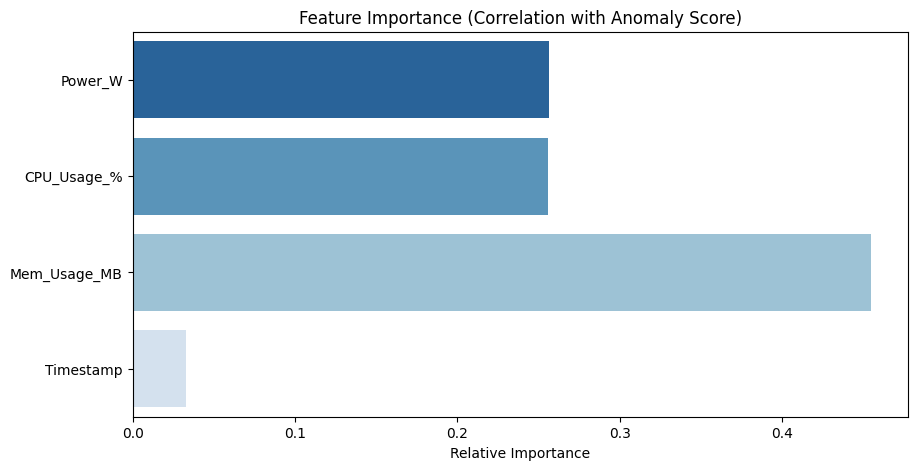

In [58]:
# ===========================================
#         FEATURE IMPORTANCE
# ===========================================
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

feature_importance = []
for i, col in enumerate(num_cols):
    correlation = np.abs(np.corrcoef(X_scaled[:, i], iforest_scores)[0, 1])
    feature_importance.append(correlation)

feature_importance = np.array(feature_importance)
feature_importance = feature_importance / feature_importance. sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=num_cols, palette='Blues_r')
plt. title('Feature Importance (Correlation with Anomaly Score)')
plt.xlabel('Relative Importance')
plt.show()

In [59]:
# ===========================================
#         DETECTED ANOMALIES
# ===========================================
print("\n" + "=" * 60)
print("DETECTED ANOMALIES")
print("=" * 60)

anomalies_df = unlabelled_df[unlabelled_df['Ensemble_Prediction'] == 1]. copy()
anomalies_df = anomalies_df.sort_values('Risk_Score', ascending=False)

print(f"\nTotal Anomalies Detected: {len(anomalies_df)}")
print(f"Anomaly Rate: {len(anomalies_df) / len(unlabelled_df) * 100:.2f}%")

print("\nTop 20 Highest Risk Anomalies:")
print("-" * 80)
display_cols = ['Process_Name', 'Power_W', 'CPU_Usage_%', 'Mem_Usage_MB', 'Risk_Score', 'Alert_Level']
print(anomalies_df[display_cols].head(20). to_string())



DETECTED ANOMALIES

Total Anomalies Detected: 32
Anomaly Rate: 1.41%

Top 20 Highest Risk Anomalies:
--------------------------------------------------------------------------------
                      Process_Name   Power_W  CPU_Usage_%  Mem_Usage_MB  Risk_Score Alert_Level
2002        Code Helper (Renderer)  1.304325        102.3    626.343750   85.784028  🔴 CRITICAL
598                      accountsd  0.728640         75.9     15.199219   79.665583      🟠 HIGH
2074                  DTServiceHub  0.024225          1.9      7.328125   77.638335      🟠 HIGH
943                   DTServiceHub  0.019200          2.0      8.351562   74.020790      🟠 HIGH
176               UniversalControl  0.013500          0.9      6.644531   72.071796      🟠 HIGH
540                           java  0.003000          0.2      4.234375   69.979335      🟠 HIGH
2201                         gamed  0.010200          0.8     10.093750   69.336665      🟠 HIGH
2149                          java  0.002550     

In [60]:
# ===========================================
#         SAVE RESULTS
# ===========================================
print("\n" + "=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save full results
unlabelled_df. to_csv("../data/anomaly_detection_results. csv", index=False)
print("Full results saved to '../data/anomaly_detection_results.csv'")

# Save anomalies only
anomalies_df. to_csv("../data/detected_anomalies. csv", index=False)
print(f"Anomalies saved to '../data/detected_anomalies.csv' ({len(anomalies_df)} records)")


SAVING RESULTS
Full results saved to '../data/anomaly_detection_results.csv'
Anomalies saved to '../data/detected_anomalies.csv' (32 records)


In [61]:
# ===========================================
#         SUMMARY STATISTICS
# ===========================================
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print(f"""
╔══════════════════════════════════════════════════════════════╗
║                    DETECTION SUMMARY                          ║
╠══════════════════════════════════════════════════════════════╣
║  Total Samples Analyzed:     {len(X_scaled):>10}                      ║
║                                                              ║
║  INDIVIDUAL MODELS:                                          ║
║    Isolation Forest:         {(y_pred_iforest == -1).sum():>10} ({(y_pred_iforest == -1).sum()/len(X_scaled)*100:>5.2f}%)          ║
║    LOF:                      {(y_pred_lof == -1).sum():>10} ({(y_pred_lof == -1).sum()/len(X_scaled)*100:>5.2f}%)          ║
║                                                              ║
║  ENSEMBLE METHODS:                                           ║
║    Averaging:                {ensemble_pred_avg. sum():>10} ({ensemble_pred_avg.sum()/len(X_scaled)*100:>5.2f}%)          ║
║    Weighted Avg:             {ensemble_pred_weighted.sum():>10} ({ensemble_pred_weighted. sum()/len(X_scaled)*100:>5.2f}%)          ║
║    Voting (Union):           {y_pred_ensemble_union.sum():>10} ({y_pred_ensemble_union.sum()/len(X_scaled)*100:>5.2f}%)          ║
║    Voting (Intersection):    {y_pred_ensemble_intersection.sum():>10} ({y_pred_ensemble_intersection.sum()/len(X_scaled)*100:>5.2f}%)          ║
║                                                              ║
║  RISK LEVELS:                                                ║
║    🔴 Critical:              {(risk_scores >= 80).sum():>10}                      ║
║    🟠 High:                  {((risk_scores >= 60) & (risk_scores < 80)).sum():>10}                      ║
║    🟡 Medium:                {((risk_scores >= 40) & (risk_scores < 60)).sum():>10}                      ║
║    🔵 Low:                   {((risk_scores >= 20) & (risk_scores < 40)).sum():>10}                      ║
║    🟢 Minimal:               {(risk_scores < 20).sum():>10}                      ║
╚══════════════════════════════════════════════════════════════╝
""")

# Top anomalous processes
print("\n" + "-" * 60)
print("TOP 10 MOST ANOMALOUS PROCESSES:")
print("-" * 60)
top_anomalies = unlabelled_df. nlargest(10, 'Risk_Score')
for idx, row in top_anomalies.iterrows():
    print(f"  {row['Alert_Level']} {row['Process_Name'][:35]:<35} | Risk: {row['Risk_Score']:.1f}%")


FINAL SUMMARY

╔══════════════════════════════════════════════════════════════╗
║                    DETECTION SUMMARY                          ║
╠══════════════════════════════════════════════════════════════╣
║  Total Samples Analyzed:           2263                      ║
║                                                              ║
║  INDIVIDUAL MODELS:                                          ║
║    Isolation Forest:                114 ( 5.04%)          ║
║    LOF:                             109 ( 4.82%)          ║
║                                                              ║
║  ENSEMBLE METHODS:                                           ║
║    Averaging:                        18 ( 0.80%)          ║
║    Weighted Avg:                     32 ( 1.41%)          ║
║    Voting (Union):                  147 ( 6.50%)          ║
║    Voting (Intersection):            76 ( 3.36%)          ║
║                                                              ║
║  RISK LEVELS:           

In [62]:
# # ===========================================
# #         ENSEMBLE RESULTS
# # ===========================================
# print("\n" + "=" * 60)
# print("ENSEMBLE (ISOLATION FOREST + LOF)")
# print("=" * 60)

# # Ensemble Strategy 1: Union (flag if EITHER method detects)
# y_pred_ensemble_union = np.where(
#     (y_pred_iforest == -1) | (y_pred_lof == -1), -1, 1
# )

# # Ensemble Strategy 2: Intersection (flag if BOTH methods detect)
# y_pred_ensemble_intersection = np.where(
#     (y_pred_iforest == -1) & (y_pred_lof == -1), -1, 1
# )

# print(f"\nEnsemble Results (Union - Either method):")
# print(f"  Anomalies detected: {(y_pred_ensemble_union == -1).sum()}")
# print(f"  Anomaly rate: {(y_pred_ensemble_union == -1). sum() / len(X_scaled) * 100:.2f}%")

# print(f"\nEnsemble Results (Intersection - Both methods):")
# print(f"  Anomalies detected: {(y_pred_ensemble_intersection == -1).sum()}")
# print(f"  Anomaly rate: {(y_pred_ensemble_intersection == -1).sum() / len(X_scaled) * 100:.2f}%")

# # Comparison Bar Chart
# plt.figure(figsize=(12, 6))
# methods = ['Isolation Forest', 'LOF', 'Ensemble (Union)', 'Ensemble (Intersection)']
# anomaly_counts = [
#     (y_pred_iforest == -1).sum(),
#     (y_pred_lof == -1).sum(),
#     (y_pred_ensemble_union == -1). sum(),
#     (y_pred_ensemble_intersection == -1).sum()
# ]
# colors = ['steelblue', 'forestgreen', 'orange', 'purple']
# bars = plt.bar(methods, anomaly_counts, color=colors, edgecolor='black')
# plt.ylabel('Anomalies Detected')
# plt.title('Model Comparison - Anomalies Detected')
# for bar, count in zip(bars, anomaly_counts):
#     plt.text(bar.get_x() + bar. get_width()/2, bar.get_height() + 5, 
#              str(count), ha='center', fontweight='bold')
# plt.xticks(rotation=15)
# plt.tight_layout()
# plt.show()

In [63]:
# # ===========================================
# #         FEATURE IMPORTANCE (Permutation-based)
# # ===========================================
# print("\n" + "=" * 60)
# print("FEATURE IMPORTANCE")
# print("=" * 60)

# # Calculate feature importance based on score variance per feature
# feature_importance = []
# for i, col in enumerate(num_cols):
#     # Correlation between feature values and anomaly scores
#     correlation = np.abs(np.corrcoef(X_scaled[:, i], iforest_scores)[0, 1])
#     feature_importance.append(correlation)

# # Normalize
# feature_importance = np.array(feature_importance)
# feature_importance = feature_importance / feature_importance.sum()

# plt.figure(figsize=(10, 5))
# sns.barplot(x=feature_importance, y=num_cols, palette='Blues_r')
# plt. title('Feature Importance (Correlation with Anomaly Score)')
# plt.xlabel('Relative Importance')
# plt.show()

In [64]:
# # ===========================================
# #         ADD PREDICTIONS TO DATAFRAME
# # ===========================================
# print("\n" + "=" * 60)
# print("ADDING PREDICTIONS TO DATAFRAME")
# print("=" * 60)

# # Add predictions to original dataframe
# unlabelled_df['IForest_Prediction'] = y_pred_iforest
# unlabelled_df['IForest_Score'] = iforest_scores
# unlabelled_df['LOF_Prediction'] = y_pred_lof
# unlabelled_df['LOF_Score'] = lof_scores
# unlabelled_df['Ensemble_Prediction'] = y_pred_ensemble_intersection
# unlabelled_df['Is_Anomaly'] = unlabelled_df['Ensemble_Prediction'].apply(
#     lambda x: 'Anomaly' if x == -1 else 'Normal'
# )

# # Show detected anomalies
# anomalies_df = unlabelled_df[unlabelled_df['Ensemble_Prediction'] == -1]
# print(f"\nDetected Anomalies ({len(anomalies_df)} total):")
# print(anomalies_df[['Process_Name', 'Power_W', 'CPU_Usage_%', 'Mem_Usage_MB', 
#                      'IForest_Score', 'LOF_Score']].head(20))

# # Save results
# unlabelled_df.to_csv("../data/anomaly_detection_results.csv", index=False)
# print("\nResults saved to '../data/anomaly_detection_results.csv'")

In [65]:
# # ===========================================
# #         SUMMARY STATISTICS
# # ===========================================
# print("\n" + "=" * 60)
# print("SUMMARY STATISTICS")
# print("=" * 60)
# print(f"Total samples analyzed: {len(X_scaled)}")
# print(f"Isolation Forest anomalies: {(y_pred_iforest == -1).sum()} ({(y_pred_iforest == -1).sum()/len(X_scaled)*100:.2f}%)")
# print(f"LOF anomalies: {(y_pred_lof == -1).sum()} ({(y_pred_lof == -1).sum()/len(X_scaled)*100:.2f}%)")
# print(f"Ensemble (intersection) anomalies: {(y_pred_ensemble_intersection == -1).sum()} ({(y_pred_ensemble_intersection == -1).sum()/len(X_scaled)*100:.2f}%)")

# # Top anomalous processes
# print("\n" + "-" * 40)
# print("TOP 10 MOST ANOMALOUS PROCESSES:")
# print("-" * 40)
# top_anomalies = unlabelled_df.nsmallest(10, 'IForest_Score')
# for idx, row in top_anomalies.iterrows():
#     print(f"  • {row['Process_Name'][:40]:<40} | Score: {row['IForest_Score']:.4f}")